# Reversal of the impact chain - glacier example: 
## Notebook creates fitted remaining glacier mass in 2100 relative to global mean temperature above pre-industrial

This notebook uses glacier model projections of the year 2100 from in total three glacier models that were forced with CMIP5 and CMIP6 climate models. Projections and model versions are as described in Zekollari et al., 2024 ([10.5194/egusphere-2024-1013](https://doi.org/10.5194/egusphere-2024-1013)). The DOIs to the original data of the  three participating glacier models are here:
- GloGEM : [10.5281/zenodo.10908277](https://zenodo.org/doi/10.5281/zenodo.10908277)  (see also original publication, i.e., [Huss&Hock, 2015](https://doi.org/10.3389/feart.2015.00054))
- OGGM v161 : [10.5281/zenodo.8286065](https://doi.org/10.5281/zenodo.8286065) (see also documentation: https://docs.oggm.org/en/stable/, the [OGGM v161 code version](https://doi.org/10.5281/zenodo.8287580), and the original publication, i.e., [Maussion et al., 2019](https://doi.org/10.5194/gmd-12-909-2019)) 
- PyGEM-OGGM : [10.5067/P8BN9VO9N5C7](https://nsidc.org/data/hma2_ggp/versions/1) (see also documentation: https://pygem.readthedocs.io/en/latest/introduction.html and original publication, i.e., [Rounce et al., 2023](https://doi.org/10.1126/science.abo1324)) 

If you run the notebook, partly postprocessed data from these DOIs are directly downloaded from the OGGM cluster. If you don't want to install OGGM, you can also directly use the aggregated and postprocessed csv file for the period and region of interest (i.e. `glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv`).  

----
**The notebook creates the following datasets and figures for glaciers in High Mountain Asia (HMA, i.e., RGI13-14-15)**:
- aggregated glacier volume change model projections in 2100 (% rel. to 2020): 
    - `glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv`
        - `global_temp_ch_2071-2100_preindustrial`: is here the global mean temperature change in °C
        - `region` : region is here for all estimates RGI13-14-15
        - `year` : year is here for all estimates 2100 
        - `rel_ice_%_2020`: is here the regional remaining glacier mass relative to the year 2020 (in %)
        - `model`: is here the glacier model (OGGM, PyGEM-OGGM, or GloGEM, see below)
        - `cmip`: Either CMIP5 or CMIP6 
        - `gcm_scenario`: combination of climate model (GCM) and scenario used
- does a LOWESS fit for many percentiles to estimate glacier change projections relative to a given global mean temperature change (GMT):
    - `lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv`
        - `deltaTemp`: is here the global mean temperature change in °C
        - `region` : region is here for all estimates RGI13-14-15
        - `frac` : the chosen hyperparameter of how much data points are applied for the local regression, here 0.48 (see [MOEPY package documentation](https://ayrtonb.github.io/Merit-Order-Effect/))
        - `q0.01, ...q0.50, ... q0.99`: LOWESS quantile regression estimates of regional glacier mass relative to the year 2020 (in %)
- creates a figure for the methods part of Pfleiderer et al., 2024 (Nature Geosciences)
    - `fig6.pdf`, `fig.6.png`

**Methods are described in Pfleiderer et al. (2024, Nature Geosciences) under the  `methods application 3 description` and some details are given below:**
- about the glacier model projections:
    - we weight every glacier model/gcm/scenario combination equally for the fit
    - OGGM has 109 experiments available, some glacier models have less experiments available than others (PyGEM: 78, GloGEM: 51)
- about the LOWESS fits:
    - similarly as done here https://github.com/lilianschuster/glacier-model-projections-until2300
        - LOWESS fits done with the MOEPY package -> https://ayrtonb.github.io/Merit-Order-Effect/ug-08-lowess-quick-start/#quantile
        - we computed percentiles from 1 to 99th percentile in "1%" steps
        - here we only do the fit over the three regions RGI13-14-15 together (but it could in theory be repeated for other regions)
- global mean temperature above pre-industrial here defined as done in IPCC AR6 WG1, that means:
    - we assume 0.69°C warming from preindustrial levels (1850-1900) to 1986-2005 for every gcm, then use the warming as given by individual gcms ... 

---

In [98]:
import pandas as pd
import numpy as np # this needs to be numpy<2.0
import xarray as xr
import os
import matplotlib.pyplot as plt
import seaborn as sns
print(pd.__version__, np.__version__, xr.__version__, sns.__version__)

2.1.3 1.24.4 2023.11.0 0.13.2


In [105]:
# you can install this via pip install moepy oggm progressbar2 
try:
    import moepy
    from moepy import lowess, eda   # this is the LOWESS fitting library that we use ... 
    import oggm  # only necessary for some additional glacier characteristics 
    import geopandas as gpd
    print('OGGM version:', oggm.__version__, '; MOEPY version:', moepy.__version__)
except:
    # if you just want to look into the data, you don't need these packages
    pass 

OGGM version: 1.6.2 ; MOEPY version: 0.0.3


In [26]:
try:
    # just to get some statistics on HMA glaciers (fot that we need oggm)
    import oggm
    df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
    rgidf_l = []
    for r in ['13', '14', '15']: 
        path_rgi = oggm.utils.get_rgi_region_file(r, version='6')
        rgidf = gpd.read_file(path_rgi)
        rgidf_l.append(rgidf)
    rgidf = pd.concat(rgidf_l)
    print('amount of glaciers in High Mountain Asia (HMA, RGI13-14-15):', + len(df_itmix.loc[rgidf.RGIId]) )
    hma_vol = df_itmix.loc[rgidf.RGIId]['vol_itmix_m3'].sum()/1e9
    print('HMA glacier volume at inventory date: ', hma_vol.round(1), 'km³')
    print('HMA volume rel. to global volume at inventory date: ' , (100*hma_vol / (df_itmix['vol_itmix_m3'].sum()/1e9)).round(1), '%')
except:
    # if OGGM is not installed
    pass

amount of glaciers in High Mountain Asia (HMA, RGI13-14-15): 95536
HMA glacier volume at inventory date:  7013.3 km³
HMA volume rel. to global volume at inventory date:  4.4 %


**Aggregate the relevant glacier projection data for High Mountain Asia from Zekollari et al., in review and the respective GMT changes**

In [106]:
######## glacier projections from Zekollari et al. (2024)
# paths in the OGGM cluster where the different data is located, these will be later automatically downloaded in a folder called oggm_cluster_data
try:
    from oggm import cfg
    # save the files in a subfolder under oggm_cluster_data
    cfg.PATHS['working_dir'] = 'oggm_cluster_data'
    path_d = {}
    ## originally comes from  https://doi.org/10.5281/zenodo.8286065
    path_d['OGGM']  = 'https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1/common_running_2100/volume/'
    ## originally comes from https://nsidc.org/data/hma2_ggp/versions/1
    path_d['PyGEM-OGGM'] = 'https://cluster.klima.uni-bremen.de/~lschuster/create_csv_files_CMIP_for_Zekollari_et_al_protect/PyGEM-OGGM/'  
    ## comes from https://zenodo.org/doi/10.5281/zenodo.10908277
    path_d['GloGEM'] = 'https://cluster.klima.uni-bremen.de/~lschuster/provide/reversal_impact_chain_glaciers_pfleiderer/GloGEM_Zekollari_et_al_2024/Volume/'  
except:
    pass
    # however, if you are just interested in the aggregated result you can just
    # use the already aggregated csv dataset, and you don't need OGGM to be installed
    # the aggregated dataset is: 'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv' (see below)

In [107]:
load = False
# this aggregates the data (if you are only interested in the results, just open the dataset)
# - sums up the regions RGI13, RGI14 and RGI 15) 
# - creates relative volume projections (% rel. to 2020)
# - only selects the year 2100 
# - creates one csv that includes all glacier models, gcms and scenarios, together with the estimated global mean temperature change for that scenario
if not load: 
    pd_fit_data_all = pd.read_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=[0])
else:
    ##### GMT changes for different GCMs of CMIP5 and CMIP6
    # you can directly download these files from the following urls, or let OGGM do that
    _file_cmip5 = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv', reset=True)
    _file_cmip6 = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv', reset=True)
    ## cmip5
    pd_cmip5_temp_ch_2100 = pd.read_csv(_file_cmip5, index_col=0)
    pd_cmip5_temp_ch_2100['cmip'] = 'CMIP5'
    ## cmip6
    pd_cmip6_temp_ch_2100 = pd.read_csv(_file_cmip6, index_col=0)
    pd_cmip6_temp_ch_2100['cmip'] = 'CMIP6'

    # change this path to your local path 
    pd_cmip_temp_ch_2100 = pd.concat([pd_cmip6_temp_ch_2100, pd_cmip5_temp_ch_2100])
    # use all scenarios except ssp534-over
    pd_cmip_temp_ch_2100 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.ssp != 'ssp534-over']

    t_min, t_max = pd_cmip_temp_ch_2100['global_temp_ch_2071-2100_preindustrial'].min(), pd_cmip_temp_ch_2100['global_temp_ch_2071-2100_preindustrial'].max()
    print(t_min, t_max)

    rgi_regs_global = ['global','01', '02', '03', '04', '05', '06', '07',
                       '08', '09', '10', '11', '12', '13', '14', '15',
                       '16', '17', '18', '19', '13-14-15']
    
    end_year = '2100'
    pd_fit_data_reg_l = []
    for jj,_rgi_reg in enumerate(['13-14-15']): 
        _pd_fit_data_l = []
        if _rgi_reg !='global':
            rgi_reg = f'RGI{_rgi_reg}'
        else:
            rgi_reg = _rgi_reg 

        for cmip in ['CMIP5','CMIP6']:
            pd_cmip = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.cmip == cmip]
            # check that there are temperature values in 2300 available ... 
            pd_cmip = pd_cmip.loc[pd_cmip['global_temp_ch_2071-2100_preindustrial'].dropna().index]
            for gcm_scenario in pd_cmip.index:
                for m in path_d.keys():
                    try:
                        _pd_fit_data = pd.DataFrame(columns=['global_temp_ch_2071-2100_preindustrial','region', 'year', 'rel_ice_%_2020'])

                        gcm, scenario = gcm_scenario.split('_')
                        path = path_d[m]
                        gcm_scenario_m = gcm_scenario + '_' + m
                        n = len(gcm_scenario)
                        if _rgi_reg == '13-14-15':
                            df = 0
                            for sub_rgi_reg in ['RGI13','RGI14','RGI15']:
                                if m == 'GloGEM':
                                    idir = path + f'{sub_rgi_reg}/'
                                else:
                                    idir = path + f'{cmip}/{end_year}/{sub_rgi_reg}/'
                                p = oggm.utils.file_downloader(idir + f'{scenario}.csv')
                                _df = pd.read_csv(p, index_col=0)
                                _df.columns = [g.upper() for g in _df.columns]
                                _df = _df[gcm.upper()]
                                df += _df
                        else:
                            if m == 'GloGEM':
                                idir = path + f'{rgi_reg}/'
                            else:
                                idir = path  + f'{cmip}/{end_year}/{rgi_reg}/'
                            p = oggm.utils.file_downloader(idir + f'{scenario}.csv')
                            df = pd.read_csv(p, index_col=0).dropna()
                            df.columns = [g.upper() for g in df.columns]
                            df = df[gcm.upper()]

                        df = df.loc[2020:]

                        df_rel = 100*df/df.loc[2020]
                        #df_rel = df_rel.loc[2020]
                        _pd_fit_data.year = df_rel.index.astype(int)
                        _pd_fit_data['rel_ice_%_2020'] = df_rel.values
                        _pd_fit_data['global_temp_ch_2071-2100_preindustrial'] = pd_cmip.loc[gcm_scenario, 'global_temp_ch_2071-2100_preindustrial']
                        _pd_fit_data['region'] = f'{rgi_reg}'
                        _pd_fit_data['model'] = m
                        _pd_fit_data['cmip'] = cmip
                        _pd_fit_data['gcm_scenario'] = gcm_scenario
                        _pd_fit_data_l.append(_pd_fit_data)
                    except:
                        if cmip == 'CMIP5' and m == 'GloGEM':
                            pass
                        else:
                            pass 
                            #print(cmip, m, gcm_scenario)
        pd_fit_data_reg = pd.concat(_pd_fit_data_l)
        pd_fit_data_reg = pd_fit_data_reg.reset_index(drop=True)
        pd_fit_data_reg_l.append(pd_fit_data_reg)
    pd_fit_data_all = pd.concat(pd_fit_data_reg_l)
    pd_fit_data_all = pd_fit_data_all.reset_index(drop=True)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']>=0)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']<=300)

    print(pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].min(), pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].max())
    print(pd_fit_data_all['model'].unique())
    print(pd_fit_data_all['rel_ice_%_2020'].min(), pd_fit_data_all['rel_ice_%_2020'].max())
    print(pd_fit_data_all['year'].min(), pd_fit_data_all['year'].max())
    # actually we are only interested in the 2100 values ... 
    pd_fit_data_all = pd_fit_data_all.loc[pd_fit_data_all.year == 2100]
    pd_fit_data_all = pd_fit_data_all.reset_index(drop=True)
    pd_fit_data_all.to_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv')


In [108]:
# check that we have the correct region and year
assert np.all(pd_fit_data_all.region == 'RGI13-14-15')
assert np.all(pd_fit_data_all.year == 2100)
pd_raw_data_sel = pd_fit_data_all.copy()

_pd_sel = pd_raw_data_sel.loc[pd_raw_data_sel.region == 'RGI13-14-15']
_pd_sel = _pd_sel.loc[_pd_sel.year == 2100]

In [109]:
try:
    # estimate the available and the used scenarios with GMT estimates
    def unique_items(list1, list2):
        unique_in_list1 = set(list1) - set(list2)
        unique_in_list2 = set(list2) - set(list1)
        return list(unique_in_list1), list(unique_in_list2)

    m = 'GloGEM'
    cmip = 'CMIP6'

    for m in ['OGGM', 'GloGEM', 'PyGEM-OGGM']:
        for cmip in ['CMIP5','CMIP6']:
            if cmip == 'CMIP5':
                scenarios = ['rcp26', 'rcp45','rcp85']
                if m == 'OGGM':
                    scenarios = scenarios + ['rcp60']
            else:
                scenarios = ['ssp119', 'ssp126','ssp245','ssp370','ssp585']
                if m == 'OGGM':
                    scenarios = scenarios + ['ssp434','ssp460']
            if cmip == 'CMIP5' and m=='GloGEM':
                pass
            else:
                gcm_scenarios = []

                path = path_d[m]

                for scenario in scenarios:
                    sub_rgi_reg = 'RGI13'
                    if m == 'GloGEM':
                        idir = path + f'{sub_rgi_reg}/'
                    else:
                        idir = path + f'{cmip}/2100/{sub_rgi_reg}/'
                        
                    p = oggm.utils.file_downloader(idir + f'{scenario}.csv')
                    _df = pd.read_csv(p, index_col=0).dropna(axis=1)
                    for c in _df.columns:
                        gcm_scenarios.append(c +'_' +  scenario)
                used_gcm_scenarios = _pd_sel.loc[(_pd_sel.cmip==cmip) & (_pd_sel.model==m)].gcm_scenario.values
                unique_list1, unique_list2 = unique_items(gcm_scenarios, used_gcm_scenarios)
                
                
                # gcm-scenario combinations that are in the original publication but where we did not have GMT estimates available are given in the "unique_list"
                print(m, cmip, 'available projections with scenarios/GCMs=',len(gcm_scenarios),
                      ', used scenarios/GCMs (those with GMT estimates)=', len(used_gcm_scenarios), unique_list1, unique_list2)
except:
    print('individual csv files have not been prescribed, but not necessary for the next steps')
# amount of experiments per model that will participate in the fit
pd_raw_data_sel.groupby('model').count()['gcm_scenario']

OGGM CMIP5 available projections with scenarios/GCMs= 40 , used scenarios/GCMs (those with GMT estimates)= 40 [] []
OGGM CMIP6 available projections with scenarios/GCMs= 69 , used scenarios/GCMs (those with GMT estimates)= 69 [] []
GloGEM CMIP6 available projections with scenarios/GCMs= 51 , used scenarios/GCMs (those with GMT estimates)= 51 [] []
PyGEM-OGGM CMIP5 available projections with scenarios/GCMs= 30 , used scenarios/GCMs (those with GMT estimates)= 27 ['GFDL-ESM2M_rcp26', 'GFDL-ESM2M_rcp85', 'GFDL-ESM2M_rcp45'] []
PyGEM-OGGM CMIP6 available projections with scenarios/GCMs= 52 , used scenarios/GCMs (those with GMT estimates)= 51 ['EC-EARTH3_ssp119'] []


model
GloGEM         51
OGGM          109
PyGEM-OGGM     78
Name: gcm_scenario, dtype: int64

In [110]:
pd_raw_data_sel

,global_temp_ch_2071-2100_preindustrial,region,year,rel_ice_%_2020,model,cmip,gcm_scenario
0,2.320556,RGI13-14-15,2100,46.198954,OGGM,CMIP5,CCSM4_rcp45
1,2.320556,RGI13-14-15,2100,49.737172,PyGEM-OGGM,CMIP5,CCSM4_rcp45
2,2.290734,RGI13-14-15,2100,36.982038,OGGM,CMIP5,MPI-ESM-LR_rcp45
3,2.290734,RGI13-14-15,2100,43.305751,PyGEM-OGGM,CMIP5,MPI-ESM-LR_rcp45
4,2.544987,RGI13-14-15,2100,37.980942,OGGM,CMIP5,CNRM-CM5_rcp45
...,...,...,...,...,...,...,...
233,1.711997,RGI13-14-15,2100,57.433570,PyGEM-OGGM,CMIP6,EC-EARTH3-VEG_ssp119
234,1.711997,RGI13-14-15,2100,52.614488,GloGEM,CMIP6,EC-EARTH3-VEG_ssp119
235,1.135359,RGI13-14-15,2100,73.334407,OGGM,CMIP6,CAMS-CSM1-0_ssp119
236,2.609334,RGI13-14-15,2100,34.833741,OGGM,CMIP6,MRI-ESM2-0_ssp434


Text(0, 0.5, 'Glacier mass in High-Mountain Asia\n(% rel. to 2020)')

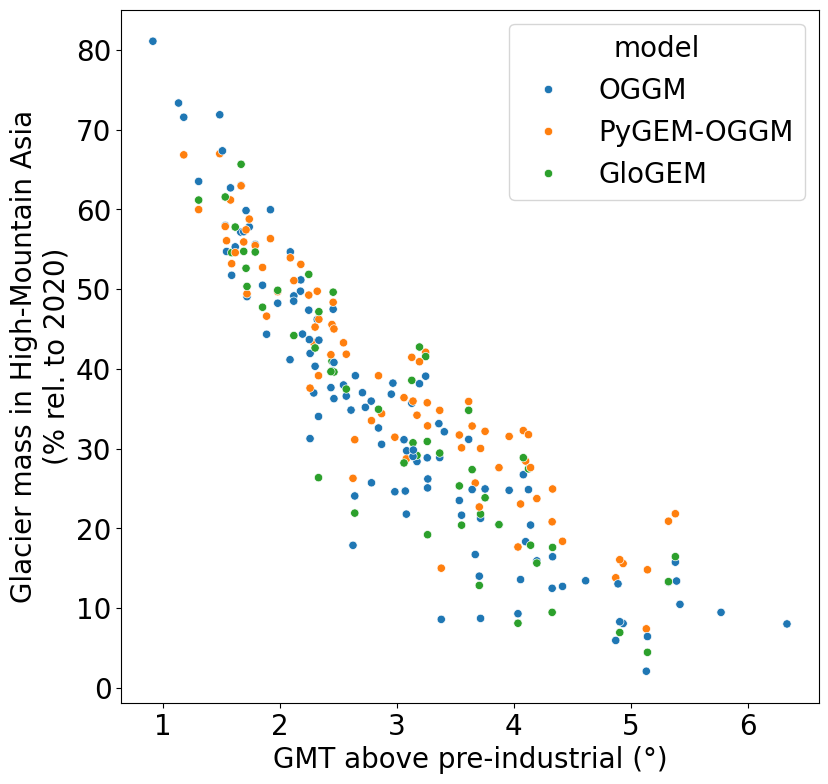

In [134]:
# quick check
plt.rc('font', size=20)
plt.figure(figsize=(9,9))
sns.scatterplot(data=pd_raw_data_sel, x= 'global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020', hue='model')
plt.xlabel('GMT above pre-industrial (°)')
plt.ylabel('Glacier mass in High-Mountain Asia\n(% rel. to 2020)')

**Do the LOWESS fit with the moepy package**

In [112]:
pd_fit_data_all = pd.read_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=0)
# we use two iterations to remove potential outliers (as a compromise between a robust fit but still sufficiently fast computational time)
it = 2
#_rgi_reg = rgi_regs_global[r]
_rgi_reg = '13-14-15'  #'global',
sim_year = 2100
N = 2000

if _rgi_reg !='global':
    region = f'RGI{_rgi_reg}'
else:
    region = _rgi_reg 
    
# Format the percentile string with leading zeros
quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}' #.format(i)  
    quantiles_str.append(_str)
    
run_lowess_fit = False
if run_lowess_fit: 
    # the lowess fit takes some time, specifically, if we use it=2
    r_pd_fit_stats = pd.DataFrame(columns=['region','year', 'fit_opt' ,'deltaTemp', 'frac','it','N'], 
                                  index = np.arange(0,400000,1))

    # this is the data we want to fit
    data = pd_fit_data_all.loc[(pd_fit_data_all.year==sim_year) & (pd_fit_data_all.region==region)]
    x = data['global_temp_ch_2071-2100_preindustrial'].values
    y = data['rel_ice_%_2020'].values

    eval_x =np.arange(x.min().round(1), x.max()*1.001, 0.05)

    jj = 0
    # when using it=1, and a larger frac range, the best frac was 0.48
    # -> let's search just around there with it=2
    for _,frac in enumerate(np.arange(0.46, 0.51,
                                      0.01)):
        # Compute the median, and a lot of quantiles 
        ind_start = (len(eval_x)-1) + (len(eval_x)-1)*jj
        ind_end = ind_start + len(eval_x)-1
        r_pd_fit_stats.loc[ind_start:ind_end,'deltaTemp'] = eval_x
        df_quantiles = lowess.quantile_model(x, y, x_pred=eval_x, frac=frac, num_fits=N, robust_iters=it,
                             qs=quantiles)
        r_pd_fit_stats.loc[ind_start:ind_end,'deltaTemp'] = eval_x
        
        j= 0
        # compute some statistics (do the quantiles go below zero, are they monotonoically decreasing???)
        for s,q in zip(quantiles_str, quantiles):
            r_pd_fit_stats.loc[ind_start:ind_end,s] = df_quantiles[q].values
            r_pd_fit_stats.loc[ind_start:ind_end,f'min_{s}_diff'] = (df_quantiles[q].iloc[:-1].values - df_quantiles[q].iloc[1:].values).min()
            r_pd_fit_stats.loc[ind_start:ind_end,f'min_{s}'] = df_quantiles[q].min()
            j+=1

        r_pd_fit_stats.loc[ind_start:ind_end,'frac'] = frac
        r_pd_fit_stats.loc[ind_start:ind_end,'it'] = it
        r_pd_fit_stats.loc[ind_start:ind_end,'N'] = N
        r_pd_fit_stats.loc[ind_start:ind_end,'fit_opt'] = 'lowess_predi'
        jj += 1
        print(frac)


    r_pd_fit_stats = r_pd_fit_stats.dropna(how='all')
    r_pd_fit_stats['region'] = region
    r_pd_fit_stats['year'] = sim_year
    r_pd_fit_stats[r_pd_fit_stats.columns[3:]] = r_pd_fit_stats[r_pd_fit_stats.columns[3:]].astype(float)
        
    # this should be true at least for the median fit .. .
    q = 'q0.50'
    _r_pd_fit_stats_sel = r_pd_fit_stats.loc[r_pd_fit_stats[f'min_{q}']>=0]
    _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}_diff']>=0]

    for q in quantiles_str: 
        _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}']>=-1]

    ### now select the fit that is never increasing with GMT increase and that is never negative
    # this should be true at least for the median fit .. .
    q = 'q0.50'
    _r_pd_fit_stats_sel = r_pd_fit_stats.loc[r_pd_fit_stats[f'min_{q}']>=0]
    _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    
    # for the quantiles, we have to be a bit less strict -> for actual fitted "projections", we can then correct for that again. 
    for q in quantiles_str: 
        _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}']>=-0.58]
    
    r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
    for q in quantiles_str:
        r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        print('try with q0.02 to q0.98')
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        for q in quantiles_str[1:-1]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        print('try with q0.03 to q0.97')
        for q in quantiles_str[2:-2]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        print('try with q0.05 to q0.95')
        for q in quantiles_str[4:95]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]

    # save the best "frac"-parameter fit....
    #r_pd_fit_stats_sel[['deltaTemp','region','frac','year'] + quantiles_str].to_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv')
# load the dataset
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])


**Create the figure 6**

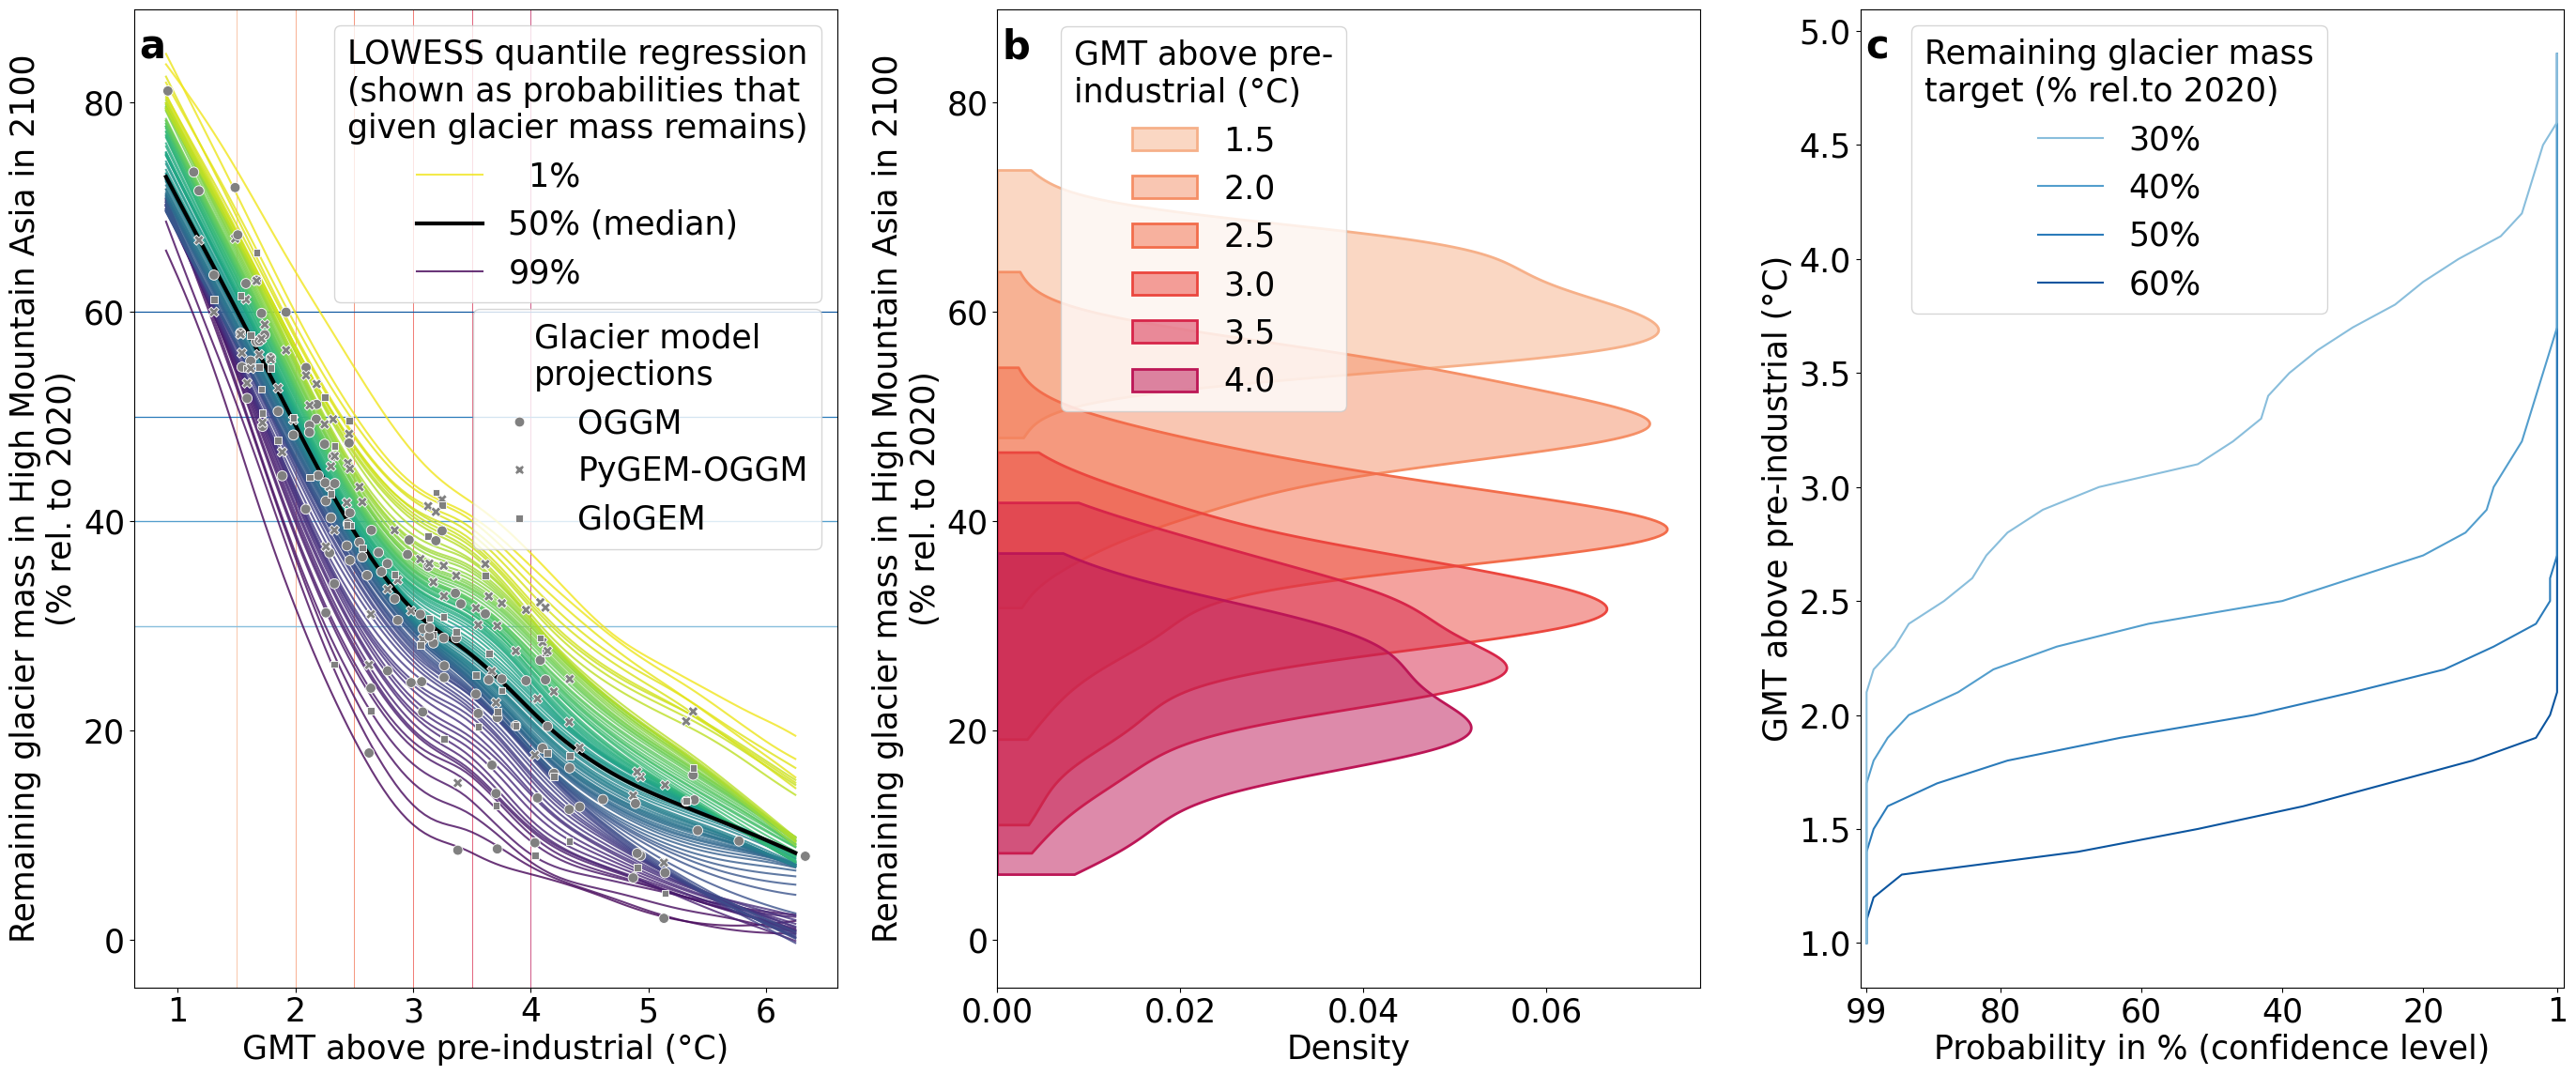

In [126]:
plt.rc('font', size=25)

pd_raw_data_sel = pd.read_csv('glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=[0])
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])
quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}'  # Format the percentile string with leading zeros
    quantiles_str.append(_str)
    
    
pd_fit.index = pd_fit.deltaTemp.values.round(2)

pd_fit_v = pd_fit[quantiles_str].T
pd_fit_v['q'] = quantiles

_pd_fit_v = pd_fit_v.copy()
_pd_fit_v.index = np.arange(0.01, 1,0.01)

assert len(pd_fit.frac.unique())==1
frac = pd_fit.frac.unique()[0].round(2)
colors = sns.color_palette('viridis', n_colors=100)
colors_2 = sns.color_palette('rocket_r', n_colors=12)
plt.figure(figsize=(28,12))
plt.subplot(131)


for c,q in zip(colors,quantiles_str): 
    if q == 'q0.50':
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color='black', label=q, lw=3, zorder=6)
    else:
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color=c, label=q, alpha = 0.8, zorder=5)
ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'a', fontsize=30, transform=ax.transAxes, weight='bold')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
assert labels[0] == 'q0.01'
leg = ax.legend([handles[-1],handles[49], handles[0]], 
                ['  1%', '50% (median)', '99%'], 
                #[labels[0],labels[49], labels[-1]], 
                title=f'LOWESS quantile regression\n(shown as probabilities that\ngiven glacier mass remains)')
plt.ylabel('Remaining glacier mass in High Mountain Asia in 2100\n(% rel. to 2020)')
plt.xlabel('GMT above pre-industrial (°C)') # Global mean temperature relative to preindustrial 

_pd_sel = pd_raw_data_sel.loc[pd_raw_data_sel.region == 'RGI13-14-15']
_pd_sel = _pd_sel.loc[_pd_sel.year == 2100]
sns.scatterplot(data= _pd_sel, x= 'global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020', style='model', zorder=15, color='grey', s=60)
handles, labels = ax.get_legend_handles_labels()
for h in handles[-3:]:
    h.set_color('grey')
ax.get_legend().remove()
leg2 = ax.legend(handles[-3:], labels[-3:], loc = 'upper right', title = 'Glacier model\nprojections',
                 bbox_to_anchor=(1,0.71))
ax.add_artist(leg)
for j,t in enumerate(np.arange(1.5,4.5,0.5)):
    plt.axvline(t, lw=0.5,  color=colors_2[1:-4][j])
ylim = ax.get_ylim()

palette= list(sns.color_palette('Blues'))
j = 0
for perc,c in zip([30,40,50,60],palette[2:]): 
    plt.axhline(perc, lw=1-j*0.05,  color=c)
    j+=1

    
    
plt.subplot(132)
ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'b', fontsize=30, transform=ax.transAxes, weight='bold')
bw = 1
for j, t in enumerate(np.arange(1.5,4.5,0.5)):
    sns.kdeplot(data=pd_fit_v[[t]], y= pd_fit_v[t],
                color=colors_2[1:-4][j], legend=True, cut=0,
               fill=True, alpha=0.5,lw=2, bw_adjust=bw,
               common_norm=True, label=f'{t}')
plt.legend() 
plt.ylabel('Remaining glacier mass in High Mountain Asia in 2100\n(% rel. to 2020)')

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.52,0.999))
leg.set_title('GMT above pre-\nindustrial (°C)')
ax.set_ylim(ylim)
#####################################################

plt.subplot(133)
# store pd_fit in an xarray
quantiles = xr.DataArray(pd_fit_v.T.values[:-1], dims=['gmt','q'],
                         coords=dict(gmt=pd_fit_v.columns.values[:-1], q=[float(s[1:]) for s in pd_fit_v.index.values]))

def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of keeping the threshold amount of glacier at given GMT g
    '''
    y = quantiles.sel(gmt=g, method='nearest')
    return 1 - quantiles.q.values[np.abs(y - thresh).argmin()]

gmt_axis = np.arange(1,5,0.1)
j = 0 
for perc,c in zip([30,40,50,60],palette[2:]): 
    p = np.array([prob_greater_at_gmt(g, perc) for g in gmt_axis])
    plt.plot(p*100, gmt_axis, '-', color=c, label = f'{perc}%', zorder=10-j)
    plt.ylabel('GMT above pre-industrial (°C)')
    plt.xlabel('Probability in % (confidence level)')
    plt.tight_layout()
    j +=1
plt.xlim([0.1,99.9])
plt.xticks(ticks = [1,20,40,60,80,99], labels= [1,20,40,60,80,99])
plt.gca().invert_xaxis()
plt.legend(title='Remaining glacier mass\ntarget (% rel.to 2020)', loc = 'upper left', bbox_to_anchor=(0.05,1))

ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'c', fontsize=30, transform=ax.transAxes, weight='bold')

#############################################
plt.tight_layout()
plt.savefig('fig6.png', dpi=100)
plt.savefig('fig6.pdf', dpi=200)


In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import collections
import seaborn as sns
import matplotlib
plt.rc('font', size=12)
matplotlib.rcParams['figure.figsize'] = (4,3)

In [2]:
# load data from above
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])

quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}' #.format(i)  # Format the percentile string with leading zeros
    quantiles_str.append(_str)
    
# revert the columns 
pd_fit.index = pd_fit.deltaTemp.values.round(2)
pd_fit_v = pd_fit[quantiles_str].T
pd_fit_v['q'] = quantiles

# store pd_fit in an xarray
quantiles = xr.DataArray(pd_fit_v.T.values[:-1], dims=['gmt','q'], coords=dict(gmt=pd_fit_v.columns.values[:-1], q=[float(s[1:]) for s in pd_fit_v.index.values]))

In [3]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of keeping the threshold amount of glacier at given GMT g
    '''
    y = quantiles.sel(gmt=g, method='nearest')
    return 1 - quantiles.q.values[np.abs(y - thresh).argmin()]

In [5]:
def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2100 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = collections.Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing thresh at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p.mean()

In [6]:
year = 2100

In [13]:
# load gmt in 2100 from FaIR simulations
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

In [ ]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:2100].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [8]:
# calculate the probability of keeping X% of the glacier for all 1500 scenarios
p_greater = xr.DataArray(dims=['scenario', 'thresh'], coords=dict(scenario=gmt.scenario.values, thresh=np.arange(40,70,10,'int')))
for thresh in p_greater.thresh.values:
    for scen in p_greater.scenario.values:
        p_greater.loc[scen, thresh] = prob_greater_in_scenario(scen, thresh)
xr.Dataset({'p_greater':p_greater}).to_netcdf(f'p_greater_in_{year}.nc')

In [9]:
p_greater = xr.open_dataset(f'p_greater_in_{year}.nc')['p_greater']

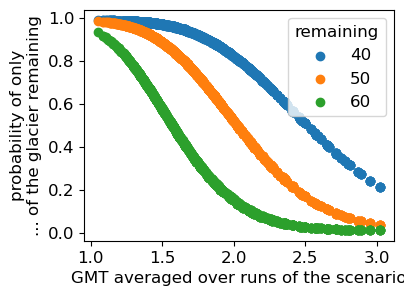

In [10]:
for thresh in p_greater.thresh.values[:]:
    plt.scatter(gmt.mean('run'),p_greater.loc[:,thresh], label=f'{thresh}')
plt.xlabel('GMT averaged over runs of the scenario')
plt.ylabel('probability of only\n... of the glacier remaining')
plt.legend(title='remaining')

In [71]:
# identify scenarios for which there is a 80% chance of keeping 50% of the glaciers
boundary_scenarios = p_greater.scenario[np.abs(p_greater.loc[:,50] - 0.80) < 0.01]

In [72]:
# select scenarios that stabilize in 2100
# -> no overshoot before 2100
# -> potential for keeping the glacier mass later on as well
selected_boundary_scenarios = boundary_scenarios[(co2.loc[boundary_scenarios].loc[:,2030] <= co2.loc[boundary_scenarios].loc[:,2020])]

In [76]:
# get cumulative CO2 emissions until 2100 in the orange scenario
CO2_budget = cum_co2.loc[selected_boundary_scenarios].values.mean()
CO2_budget

726.4899210773282